In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

# np.random.seed(2020)

In [9]:
with open('PATH/to/biorxiv/json/file') as f:
    biorxiv_positive = pd.DataFrame(json.load(f)).T
    biorxiv_positive = biorxiv_positive.rename(columns={0: "biorxiv_raw_freq", 1: "biorxiv_norm_freq"})
biorxiv_positive = biorxiv_positive.drop([2, 3], axis=1)
biorxiv_positive.index = map(str.lower, biorxiv_positive.index)
with open('PATH/to/pmc/json/file') as f:
    pmc_positive = pd.DataFrame(json.load(f)).T
    pmc_positive = pmc_positive.rename(columns={0: "pmc_raw_freq", 1: "pmc_norm_freq"})
pmc_positive = pmc_positive.drop([2, 3], axis=1)
df=pd.concat([biorxiv_positive, pmc_positive], axis=1)
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 5hmc to pubchem
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   biorxiv_raw_freq   32 non-null     object
 1   biorxiv_norm_freq  32 non-null     object
 2   pmc_raw_freq       32 non-null     object
 3   pmc_norm_freq      32 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


### We first do grid search for positive CZI phrases in the last 72 months, and store results in the pickle.

In [ ]:
# if you already have grid search results, you can uncomment this cell and comment next cell, 
# since that's the process to do grid search

# with open('PATH/to/bayesian_novelty_pmc.pickle', 'rb') as handle:
#     phrases_dict_pmc = pickle.load(handle)
# with open('PATH/to/bayesian_novelty_biorxiv.pickle', 'rb') as handle:
#     phrases_dict_biorxiv = pickle.load(handle)

In [14]:
def preprocessing(x):
    return x['pmc_raw_freq'][-72:]
df['pmc_raw_freq'] = df.apply(preprocessing, axis=1)

target_phrases = df.index.tolist()

phrases_dict_pmc = {}
phrases_dict_biorxiv = {}

def draw(phrase_name, pmc_or_biorxiv):
    cost_list = []
    parameter_list = []
    
    points = np.array(df.loc[phrase_name][pmc_or_biorxiv + '_raw_freq'])
    points = points/np.max(points)
    #------------------------------------this is the main part of bayesian modeling!!!!!just the grid search
    less_cost = 10000
    best_parameter = []

    for tau in range(72):
        for alpha in np.arange(0, 0.2, 0.001):
            for beta in np.arange(0.01, 0.3, 0.01):
                cost = 0
                for month in range(72):
                    if month < tau:
                        cost += abs(alpha - points[month])
                    else:
                        cost += abs(alpha+beta*(month-tau) - points[month])
                
                #record cost for every alpha, beta and tau
                cost_list.append(cost)
                parameter_list.append([alpha, beta, tau])
                
                if cost < less_cost:
                    less_cost = cost
                    best_parameter = [tau, alpha, beta]

    mu_t = []
    for month in range(72):
        if month < best_parameter[0]:
            mu_t.append(best_parameter[1])
        else:
            mu_t.append(best_parameter[1]+best_parameter[2]*(month-best_parameter[0]))  

    return cost_list, parameter_list

for phrase_name in target_phrases[:1]:
    print(phrase_name)
    cost_list, parameter_list = draw(phrase_name, "pmc")
    phrases_dict_pmc[phrase_name] = (cost_list, parameter_list)
    cost_list, parameter_list = draw(phrase_name, "biorxiv")
    phrases_dict_biorxiv[phrase_name] = (cost_list, parameter_list)
    
pickle.dump(phrases_dict_pmc, open('PATH/to/bayesian_novelty_pmc.pickle', 'wb'))
pickle.dump(phrases_dict_biorxiv, open('PATH/to/bayesian_novelty_biorxiv.pickle', 'wb'))

### We first sample N number of triplets from the grid search weighted by the probabilities. We then sort the samples by their tau value. We then cut off 2.5% of the samples from the start and end and resample them to measure delta. After making N samples once again we sort them by their delta values and plot its values.

In [3]:
d4_pmc_dict = {}
for phrase in phrases_dict_pmc.keys():
    cost = np.expand_dims(np.array(phrases_dict_pmc[phrase][0]), axis = 1)
    score = -cost
    ps = np.exp(score)
    ps/= np.sum(ps)
    triplets = np.array(phrases_dict_pmc[phrase][1])    
    triplets = np.concatenate((triplets, ps), axis=1)
    d4_pmc_dict[phrase] = triplets

In [4]:
N = 1000000
sample_pmc = {}
for phrase in d4_pmc_dict:
    triplets = []
    sample_index = np.random.choice(np.arange(len(d4_pmc_dict[phrase][:,3])), N, p=d4_pmc_dict[phrase][:,3])
    for index in sample_index:
        triplets.append(d4_pmc_dict[phrase][index])
    triplets = np.array(triplets)
    triplets = triplets[triplets[:,2].argsort()]
    triplets = triplets[int(N*0.025): int(N*0.975)]
    sample_pmc[phrase] = np.array(triplets)

In [5]:
d4_biorxiv_dict = {}
for phrase in phrases_dict_biorxiv.keys():
    cost = np.expand_dims(np.array(phrases_dict_biorxiv[phrase][0]), axis = 1)
#     score = -np.log(cost)
    score = -cost
    ps = np.exp(score)
    ps/= np.sum(ps)
    triplets = np.array(phrases_dict_pmc[phrase][1])    
    triplets = np.concatenate((triplets, ps), axis=1)
    d4_biorxiv_dict[phrase] = triplets

In [6]:

sample_biorxiv = {}
for phrase in d4_biorxiv_dict:
    triplets = []
    sample_index = np.random.choice(np.arange(len(d4_biorxiv_dict[phrase][:,3])), N, p=d4_biorxiv_dict[phrase][:,3])
    for index in sample_index:
        triplets.append(d4_biorxiv_dict[phrase][index])
    triplets = np.array(triplets)
    triplets = triplets[triplets[:,2].argsort()]
    triplets = triplets[int(N*0.025): int(N*0.975)]
    sample_biorxiv[phrase] = np.array(triplets)

In [18]:
delta_dict = {}
for phrase in sample_pmc:
#     tau_samples_pmc=[]
#     tau_samples_biorxiv = []
    delta = []
    sample_index_pmc = np.random.choice(np.arange(len(sample_pmc[phrase])), N)
    sample_index_biorxiv = np.random.choice(np.arange(len(sample_biorxiv[phrase])), N)
    for index in range(len(sample_index_pmc)):        
        delta.append(sample_pmc[phrase][sample_index_pmc[index],2]-sample_biorxiv[phrase][sample_index_biorxiv[index],2])
#         print(sample_pmc[phrase][sample_index_pmc[index],2]-sample_biorxiv[phrase][sample_index_biorxiv[index],2])
#         break
#     print(len(delta))
    delta = np.sort(delta)
    delta_dict[phrase] = delta[int(N*0.025): int(N*0.975)]
#     break
# print(delta_dict)

In [19]:
print(len(delta_dict['5hmc']))

950000


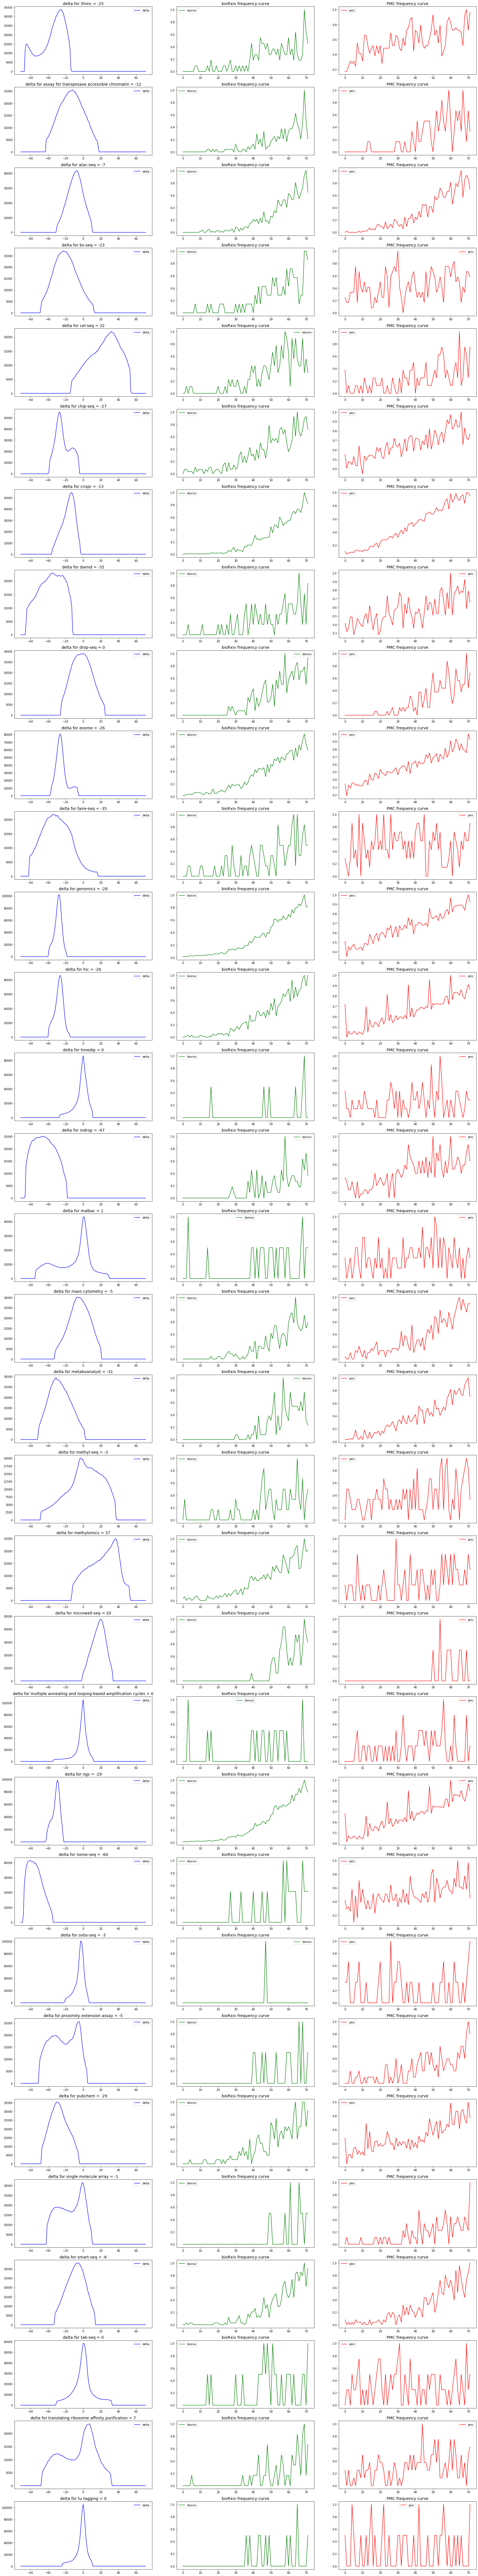

In [22]:
fig, axes = plt.subplots(len(phrases_dict_pmc.keys()),3, figsize = (24,len(phrases_dict_pmc.keys())*4))
count = 0
for phrase in delta_dict:
    points_biorxiv = np.array(df.loc[phrase]['biorxiv_raw_freq'])
    points_biorxiv = points_biorxiv/np.max(points_biorxiv)
    points_pmc = np.array(df.loc[phrase]['pmc_raw_freq'])[-72:]
    points_pmc = points_pmc/np.max(points_pmc)
    unique, counts = np.unique(delta_dict[phrase], return_counts=True)
    new_counts_delta = []
    for i in range(-71,72):
        if i not in unique:
            new_counts_delta.append(0)
        else:
            new_counts_delta.append(counts[np.where(unique == i)[0]])
#     print("delta for " + str(phrase) + " = " +  str(np.argmax(new_counts_delta)-71))
    axes[count][0].plot(np.arange(-71,72), new_counts_delta, 'b', label='delta')
#     axes[count][0].plot(np.arange(72), new_counts_pmc, 'r', label='pmc')
    axes[count][0].legend()
    axes[count][0].set_title("delta for " + str(phrase) + " = " +  str(np.argmax(new_counts_delta)-71), fontsize=14)
    axes[count][1].set_title("bioRxiv frequency curve", fontsize=14)
    axes[count][2].set_title("PMC frequency curve", fontsize=14)
    axes[count][1].plot(np.arange(72), points_biorxiv, 'g', label='biorxiv')
    axes[count][2].plot(np.arange(72), points_pmc, 'r', label='pmc')
    axes[count][1].legend()
    axes[count][2].legend()
#     plt.plot(np.arange(-71,72), new_counts_delta)
    count+=1
fig.tight_layout()
plt.show()
#     break